In [1]:
import numpy as np
from skimage.io import imread
import time
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import skimage
from skimage import io as skio
import IPython
from skimage.transform import rescale
from skimage.io import imread
from scipy.spatial import distance
import sys
from scipy.fft import dct, idct, dctn, idctn

In [2]:
#================================== Parameters initialization ==================================

sigma = 25 # variance of the noise

lamb2d = 2.0

lamb3d = 2.7

Step1_ThreDist = 250 # threshold distance

Step1_MaxMatch = 16 # max matched blocks

Step1_PatchSize = 8

Step1_spdup_factor = 3 # pixel jump for new reference block

Step1_WindowSize = 39 # search window size  

In [3]:
def addNoiseGauss(im,br=sigma):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def viewimage(im, normalize=True,z=1,order=0,titre='',displayfilename=False):
    imin=im.copy().astype(np.float32)
    imin = rescale(imin, z, order=order)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255 
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

In [16]:
# Step 1

def distpatch(patch1, patch2, khard=8):
    """
    Calcul distance entre deux patchs (sans seuillage).

    patch1, patch2: 1D arrays (flatten)
    """
    if patch1.size != patch2.size:
        print('Error: two patches should be in same size in function distpatch().\n')
        sys.exit()

    p1 = patch1.astype(np.float32)
    p2 = patch2.astype(np.float32)

    diff = p1 - p2
    dist = np.sqrt(np.sum(diff * diff)) / (khard ** 2)  # Normalization
    return dist

def grouping(im, center_i=None, center_j=None,
             patch_size=Step1_PatchSize, search_window=Step1_WindowSize,
             max_similar_patches=Step1_MaxMatch, threshard=Step1_ThreDist):
    """
    Find and group patches from the image *im*, return a 3D array of patches.

    Note that the distance computing is chosen from original paper rather than the analysis one.

    - im: 2D noised image
    - (center_i, center_j): Center of reference patch. If center = None, the center of the image will be used
    - patch_size: Size of patch (default = 8)
    - search_window: Size of the search window (in pixels)
    - max_similar_patches: Nhard
    - threshard: Distance threshold for accepting a patch
    """
    H, W = im.shape
    half_p = patch_size // 2
    half_w = search_window // 2

    # Select the center of the reference patch.
    if center_i is None:
        center_i = H // 2
    if center_j is None:
        center_j = W // 2
    center_i = np.clip(center_i, half_p, H - half_p - 1)
    center_j = np.clip(center_j, half_p, W - half_p - 1)

    # Build reference patch.
    ref_patch = im[center_i - half_p:center_i + half_p,
                   center_j - half_p:center_j + half_p]

    # Range of search window.
    i_min = max(center_i - half_w, half_p)
    i_max = min(center_i + half_w, H - half_p)
    j_min = max(center_j - half_w, half_p)
    j_max = min(center_j + half_w, W - half_p)

    similar_patches = []        # (dist, patch, (i, j))

    # Patch center.
    for i in range(i_min, i_max):
        for j in range(j_min, j_max):
            current_patch = im[i - half_p:i + half_p,
                               j - half_p:j + half_p]
            dist = distpatch(ref_patch.flatten(),
                             current_patch.flatten(),
                             khard=patch_size)
            if dist < threshard:
                similar_patches.append((dist, current_patch.copy(), (i, j)))

    # Use *ref_patch* if no similar patches are found. 
    if len(similar_patches) == 0:
        similar_patches = [(0.0, ref_patch.copy(), (center_i, center_j))] # The only one.


    # 5. Sorting. Keep the smallest *max_similar_patches* patches.
    similar_patches.sort(key=lambda x: x[0])
    selected = similar_patches[:max_similar_patches]

    patches = [p for (d, p, coord) in selected]
    coords  = [coord for (d, p, coord) in selected]

    block_3D = np.stack(patches, axis=2)

    return block_3D, coords


def hard_threshold(coeffs, l=lamb2d, sigm =sigma):
    thresh = l * sigm
    coeffs = coeffs.copy()
    coeffs[np.abs(coeffs) < thresh] = 0
    return coeffs

def ondelet_3D(block_3D):
    '''
    Transfo ondelettes 3D sur un block 3D de patchs.
    '''
    # 3D DCT
    block_3D = np.asarray(block_3D, dtype=np.float32)
    coeffs = dctn(block_3D, axes=(0, 1, 2), type=2, norm='ortho')
    return coeffs

def invondelet_3D(coeffs):
    coeffs = np.asarray(coeffs, dtype=np.float32)
    block_rec = idctn(coeffs, axes=(0, 1, 2), type=2, norm='ortho')
    return block_rec

def collaborative_filtering(block_3D, lam, sigma_noise):
    D = ondelet_3D(block_3D)
    D_thr = hard_threshold(D, lam, sigma_noise)
    block_filtered = invondelet_3D(D_thr)
    return block_filtered

def imread_gray(path):
    im = imread(path)
    if im.ndim == 3:
        im = np.mean(im, axis=2)    
    return im.astype(np.float32)

def bm3d_step1(noisy, patch_size=Step1_PatchSize, search_window=Step1_WindowSize,
           max_similar_patches=Step1_MaxMatch, step=3,
           lam=lamb3d, sigma_noise=sigma):
    noisy = noisy.astype(np.float32)
    H, W = noisy.shape
    half_p = patch_size // 2
    
    v = np.zeros_like(noisy, dtype=np.float32)
    w = np.zeros_like(noisy, dtype=np.float32)

    for i in range(half_p, H - half_p, step):
        for j in range(half_p, W - half_p, step):
            # Grouping for (i, j).
            block_3D, coords = grouping(
                noisy, center_i=i, center_j=j, patch_size=patch_size,
                search_window=search_window, max_similar_patches=max_similar_patches,
                threshard=Step1_ThreDist
            )

            block_filtered = collaborative_filtering(block_3D, lam, sigma_noise)
            num_patches = block_filtered.shape[2]

            weight = 1.0 # Can upgrade to more reasonable weights.

            for n in range(num_patches):
                pi, pj = coords[n] 
                top  = pi - half_p
                left = pj - half_p
                patch = block_filtered[:, :, n]

                v[top:top+patch_size, left:left+patch_size] += weight * patch
                w[top:top+patch_size, left:left+patch_size] += weight
    # Aovid zero-division.
    eps = 1e-8
    u_hat = v / (w + eps)

    # Special treatment for places where w == 0
    mask_zero = (w < eps)
    u_hat[mask_zero] = noisy[mask_zero]

    return u_hat

In [7]:
im = imread_gray('img/pyramide.tif')
img_n = addNoiseGauss(im, sigma)

In [12]:
# Test:
coeffs = np.array([-5, -1, 0, 2, 10], dtype=np.float32)
l = 1.5
noise = 2.0
# threshould = l * noise = 3
out = hard_threshold(coeffs, l, noise)
print("[test_hard_threshold]")
print("input :", coeffs)
print("output:", out)


[test_hard_threshold]
input : [-5. -1.  0.  2. 10.]
output: [-5.  0.  0.  0. 10.]


In [13]:
patch_size = 8
nb_patches = 4
block = np.random.randn(patch_size, patch_size, nb_patches).astype(np.float32)
coeffs = ondelet_3D(block)
recon  = invondelet_3D(coeffs)
err = np.max(np.abs(block - recon))
print("[test_transform_inverse] max abs error =", err)


[test_transform_inverse] max abs error = 7.1525574e-07


[test_one_block_denoising] block_3D shape: (8, 8, 16)
[test_one_block_denoising] num coords: 16
[test_one_block_denoising] ref_coord: (256, 256) ref_idx: 0


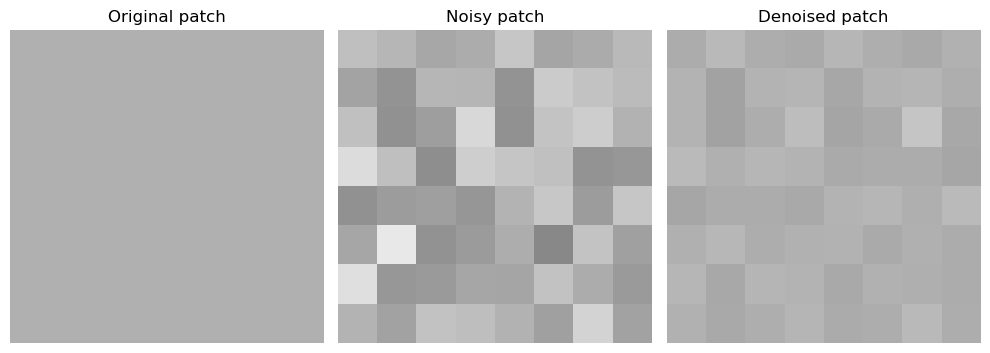

In [15]:
block_3D, coords = grouping(
    img_n,
    center_i=None,                   # 或者你可以显式给一个中心
    center_j=None,
    patch_size=patch_size,
    search_window=Step1_WindowSize,
    max_similar_patches=Step1_MaxMatch,
    threshard=Step1_ThreDist
)

print("[test_one_block_denoising] block_3D shape:", block_3D.shape)
print("[test_one_block_denoising] num coords:", len(coords))

l = 2.7
block_filtered = collaborative_filtering(block_3D, l, sigma)

H, W = img_n.shape
center_i = H // 2
center_j = W // 2
ref_coord = (center_i, center_j)

if ref_coord in coords:
    ref_idx = coords.index(ref_coord)
else:
    ref_idx = 0
    ref_coord = coords[0]
    center_i, center_j = ref_coord

print("[test_one_block_denoising] ref_coord:", ref_coord, "ref_idx:", ref_idx)
noisy_patch    = block_3D[:, :, ref_idx]
denoised_patch = block_filtered[:, :, ref_idx]

half = patch_size // 2
clean_patch = im[center_i-half:center_i+half,
                 center_j-half:center_j+half]

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(clean_patch, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Original patch")
axes[0].axis('off')

axes[1].imshow(noisy_patch, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Noisy patch")
axes[1].axis('off')

axes[2].imshow(denoised_patch, cmap='gray', vmin=0, vmax=255)
axes[2].set_title("Denoised patch")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
u_hat = bm3d_step1(img_n, search_window=11)
# If window-size is 31, it will take VERY long.
# Now it takes about 30s.

In [24]:
u_hat_21 = bm3d_step1(img_n, search_window=21)

KeyboardInterrupt: 

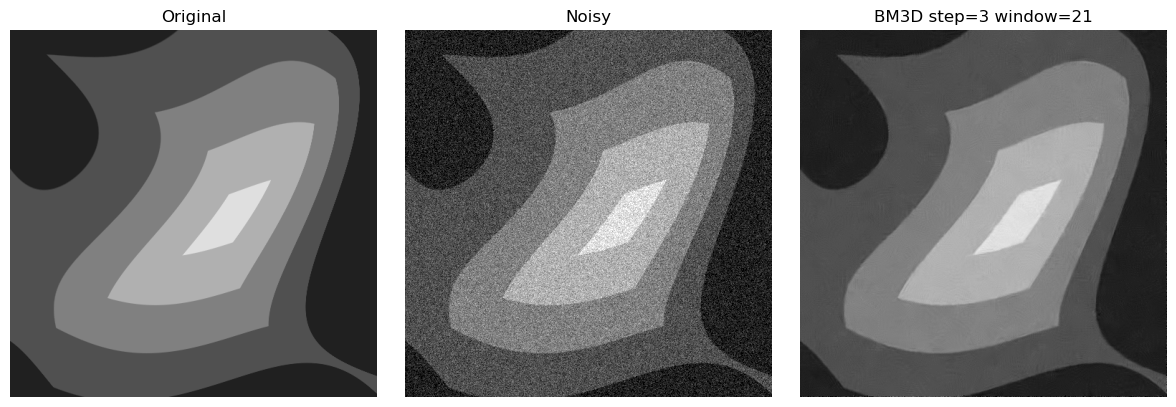

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(im, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(img_n, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Noisy")
axes[1].axis('off')

axes[2].imshow(u_hat_21, cmap='gray', vmin=0, vmax=255)
axes[2].set_title("BM3D step=3 window=21")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [1]:
# Step 2


def grouping_step2(
    basic,                 # Difference from Step1
    noisy,                 
    center_i=None,
    center_j=None,
    patch_size=8,
    search_window=16,
    max_similar_patches=16,
    threshard=250.0
):
    H, W = basic.shape
    half_p = patch_size // 2
    half_w = search_window // 2

    if center_i is None:
        center_i = H // 2
    if center_j is None:
        center_j = W // 2

    center_i = np.clip(center_i, half_p, H - half_p - 1)
    center_j = np.clip(center_j, half_p, W - half_p - 1)

    # Difference from Step1
    ref_patch_basic = basic[center_i - half_p:center_i + half_p,
                            center_j - half_p:center_j + half_p]

    # (Might not be useful, but in case...)
    ref_patch_noisy = noisy[center_i - half_p:center_i + half_p,
                            center_j - half_p:center_j + half_p]

    i_min = max(center_i - half_w, half_p)
    i_max = min(center_i + half_w, H - half_p)
    j_min = max(center_j - half_w, half_p)
    j_max = min(center_j + half_w, W - half_p)

    similar = []   # (dist, basic_patch, noisy_patch, (i,j))

    for i in range(i_min, i_max):
        for j in range(j_min, j_max):
            patch_basic = basic[i - half_p:i + half_p,
                                j - half_p:j + half_p]

            dist = distpatch(ref_patch_basic.flatten(),
                             patch_basic.flatten(),
                             khard=patch_size)
            if dist < threshard:
                # # Difference from Step1: save the patch of noisy and basic.
                patch_noisy = noisy[i - half_p:i + half_p,
                                    j - half_p:j + half_p]
                similar.append((
                    dist,
                    patch_basic.copy(),
                    patch_noisy.copy(),
                    (i, j)
                ))
    if len(similar) == 0:
        # Difference from Step1: save two patches.
        similar = [(
            0.0,
            ref_patch_basic.copy(),
            ref_patch_noisy.copy(),
            (center_i, center_j)
        )]

    similar.sort(key=lambda x: x[0])
    selected = similar[:max_similar_patches]

    PB = [p_b for (d, p_b, p_n, coord) in selected]
    PN = [p_n for (d, p_b, p_n, coord) in selected]
    coords        = [coord for (d, p_b, p_n, coord) in selected]

    basic_block_3D = np.stack(PB, axis=2)
    noisy_block_3D = np.stack(PN, axis=2)

    return basic_block_3D, noisy_block_3D, coords

def wiener(Tn, Tb_energy, sigma_noise, eps=1e-8):       # eps to avoid dividing by 0
    noise_var = sigma_noise ** 2
    a = Tb_energy / (Tb_energy + noise_var + eps)
    Tn_filtered = a * Tn
    return Tn_filtered, a
